In [30]:
import os
import functools, operator
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
server_root = './model_MNIST/server'
clients_root = './model_MNIST/clients'

def get_server_weights_fname():
    return f'{server_root}/weights'

def get_client_weights_fname(k):
    return f'{clients_root}/{k}/weights'


# Verbose

In [3]:
VERBOSE = 0

In [4]:
def log(msg):
    if VERBOSE > 0:
        print(msg)

# Data handling

In [5]:
ds = tf.keras.datasets.mnist.load_data()

In [6]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [228]:
# This function expects data to be a list/tuple of length 2 with samples and labels: (X, y)
# Both the samples and labels are split into k chunks
#
# The returned partition is a tuple of length k. Each tuple entry is a list (X, y)
# of samples and labels.
#
# TODO: extend to support non-IID
def split_data(data, k):
    partition = []
    data = (data[0][:5000], data[1][:5000])   #    !!!!!!!!!!!!! Chopped the data set size during development
    n = len(data[0])
    splits = [(n // k) * i for i in range(k)]

    for i in range(len(splits)):
        if i == len(splits) - 1:
            partition.append((data[0][splits[i]:, :],
                              data[1][splits[i]:]))
        else:
            partition.append((data[0][splits[i]:splits[i + 1], :],
                              data[1][splits[i]:splits[i + 1]]))
    return partition

# Weight-zeroing Callback

In [9]:
class ZeroMaskedWeightsCallback(tf.keras.callbacks.Callback):
    def __init__(self, debug=False):
        self.debug = debug


    def _debug_zero_weights(self, client):
        by_mask = np.count_nonzero(client.get_mask())
        by_weights = np.count_nonzero(flatten_prunable(client.model.get_weights()))
        print(f'active by mask: {by_mask}, non zero count: {by_weights}')


    def on_epoch_begin(self, epoch, logs=None):
        if self.debug:
            print('-----')
            self._debug_zero_weights(self.model.client)

        weights = self.model.get_weights()
        weights = unflatten_prunable(flatten_prunable(weights) * self.model.client.get_mask(), weights)
        self.model.set_weights(weights)

        if self.debug:
            self._debug_zero_weights(self.model.client)

# Flatten Prunable Weights

In [10]:
def flatten_prunable(weights):
    return np.concatenate([layer.reshape(1,-1) for layer in weights if layer.ndim > 1], axis=1)


def unflatten_prunable(flattened, orig_weights):
    curr_offset = 0
    result      = []

    for layer in orig_weights:
        if layer.ndim > 1:
            count = np.prod(layer.shape)
            result.append(flattened[0, curr_offset:curr_offset+count].reshape(layer.shape))
            curr_offset += count
        else:
            result.append(layer)            
    return result

## Models

In [11]:
class ClientBase:
    def __init__(self, k, model, hyper_params, X, y):
        self.k              = k
        self.model          = model
        self.model.client   = self
        self.hyper_params   = hyper_params
        self.X              = X
        self.y              = y


    def get_weights(self):
        return self.model.get_weights()


    def sample_size(self):
        return self.X.shape[0]

In [12]:
class Client_FedAvg(ClientBase):
    def __init__(self, k, model_creator, hyper_params, X, y):
        super().__init__(k, model_creator(), hyper_params, X, y)
        self.model_creator = model_creator


    def client_update(self, weights):
        self.model.set_weights(weights)
        self.model.fit(self.X, self.y,
                       batch_size=self.hyper_params['B'], epochs=self.hyper_params['E'],
                       verbose=VERBOSE)

In [13]:
class Client_LotteryFL(ClientBase):
    def __init__(self, k, model_creator, initial_weights, hyper_params, X, y):
        super().__init__(k, model_creator(), hyper_params, X, y)
        self.initial_weights = initial_weights
        self.mask            = np.ones(flatten_prunable(initial_weights).shape, dtype=int)
        self.curr_prune_rate = 0


    def prune(weights, mask, r_p):
        alive            = weights[np.nonzero(weights*mask)] # flattened array of nonzero values
        percentile_value = np.percentile(abs(alive), r_p*100)
        return np.where(abs(weights) < percentile_value, 0, mask)
    
    
    def get_mask(self):
        return self.mask

    
    # This returns a longer mask that includes 1's for all non-prunable parameters (e.g. bias)
    def get_mask_extended(self):
        curr_offset = 0
        result      = []

        for layer in self.model.get_weights():
            if layer.ndim > 1:
                count = np.prod(layer.shape)
                result.extend(self.mask[0, curr_offset:curr_offset+count])
                curr_offset += count
            else:
                result.extend(np.ones(layer.size, dtype=int))
        return np.array(result)


    def get_weights(self):
        weights = self.model.get_weights()
        return unflatten_prunable(flatten_prunable(weights) * self.mask, weights)
    

    def client_update(self, weights):
        self.model.set_weights(weights)
        acc = self.model.evaluate(self.X, self.y, return_dict=True, verbose=VERBOSE)['accuracy']
        
        print(f'Client: accuracy {acc}, prune rate {self.curr_prune_rate}')
        if acc > self.hyper_params['acc_threshold'] and self.curr_prune_rate < self.hyper_params['r_target']:
            print('Client is pruning.')
            self.mask = Client_LotteryFL.prune(flatten_prunable(weights), self.mask, self.hyper_params['r_p'])
            self.curr_prune_rate = (self.mask.size - np.count_nonzero(self.mask)) / self.mask.size
            
            new_weights = unflatten_prunable(flatten_prunable(self.initial_weights) * self.mask, self.initial_weights)
            self.model.set_weights(new_weights)
        
        self.model.fit(self.X, self.y,
                       batch_size=self.hyper_params['B'], epochs=self.hyper_params['E'],
                       callbacks=[ZeroMaskedWeightsCallback()],
                       verbose=VERBOSE)

In [14]:
def create_MNIST_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')])
    
    model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(0.001),
                     metrics=['accuracy'])
    return model

# Server

In [129]:
fm = Foreman({
    'algo': 'FedAvg',
    'data': 'MNIST_IID',
    'R': 2,
    'C': .5,
    'K': 10,
    'E': 4,
    'B': 64,
    'eta': 0.01 # currently unused
    })
fm.run()

Foreman: run with initial weights
1875/1875 [==============================] - 1s 654us/step - loss: 178.2424 - accuracy: 0.0720
Selected clients:  [1 5 8 4 9]
Selected clients:  [4 9 2 5 3]
Foreman: run with trained global model
1875/1875 [==============================] - 1s 660us/step - loss: 0.9717 - accuracy: 0.8373
Foreman: rerun with initial weights
1875/1875 [==============================] - 1s 652us/step - loss: 178.2424 - accuracy: 0.0720


In [130]:
class ServerBase(ABC):
    def __init__(self, clients, model, hyper_params, X, y):
        self.clients      = clients
        self.model        = model # the global model
        self.weights      = model.get_weights()
        self.hyper_params = hyper_params
        self.X            = X
        self.y            = y
        self.n            = functools.reduce(operator.add, [c.sample_size() for c in self.clients]) # total samples
        self.shapes       = [layer.shape for layer in self.weights]
    
    def _sampleClients(self):
        choices = np.random.choice(self.hyper_params['K'],
                                   max(1, int(self.hyper_params['C']*self.hyper_params['K'])),
                                   replace=False)
        return [self.clients[i] for i in choices]


    def _flatten(weights):
        return np.concatenate([layer.reshape(1,-1) for layer in weights], axis=1)


    def _unflatten(weights, shapes):
        curr_offset = 0
        result      = []

        for s in shapes:
            count = np.prod(s)
            result.append(weights[0, curr_offset:curr_offset+count].reshape(s))
            curr_offset += count
        return result


# PROPOSAL: replace this client-sample-based FedAvg with a FedAvg over all clients
#           which is what I think the FedAvg algorithm actually wants.
# OLD:
#     def _fed_avg_aggregate(self, clients):
#         return ServerBase._unflatten(
#             (1/self.n) * functools.reduce(operator.add,
#                                           [c.sample_size() * ServerBase._flatten(c.get_weights()) for c in clients]),
#             self.shapes)
# NEW:
# Here we ignore the parameter clients and use self.clients, which is actually what FedAvg is supposed to do.
# TODO: If accepted, get rid of argument and clean up calls.
    def _fed_avg_aggregate(self, clients):
        return ServerBase._unflatten(
            (1/self.n) * functools.reduce(operator.add,
                                          [c.sample_size() * ServerBase._flatten(c.get_weights()) for c in self.clients]),
            self.shapes)


    def get_weights(self):
        return self.weights


    @abstractmethod
    def run(self):
        pass

In [131]:
class Server_FedAvg(ServerBase):
    def __init__(self, clients, model, hyper_params, X, y):
        super().__init__(clients, model, hyper_params, X, y)
    
    def run(self):
        for r in range(self.hyper_params['R']):
            log(f'Server: round {r}')
            clients = self._sampleClients()
            for c in clients:
                log(f'Server: round {r} - client{c.k}')
                c.client_update(self.weights)
            
            self.weights = self._fed_avg_aggregate(clients)

In [120]:
class Server_LotteryFL(ServerBase):
    def __init__(self, clients, model, hyper_params, X, y):
        super().__init__(clients, model, hyper_params, X, y)
    
    def run(self):
        for r in range(self.hyper_params['R']):
            log(f'Server: round {r}')
            clients = self._sampleClients()
            for c in clients:
                log(f'Server: round {r} - client{c.k}')
                weights = unflatten_prunable(flatten_prunable(self.weights) * c.get_mask(), self.weights)
                c.client_update(weights)
            
            self.weights = self._fed_avg_aggregate(clients) # revisit this approach to aggregation for LotteryFL

In [121]:
# PROPOSAL: replace this simple FedAvg which one more appropriate for LotteryFL
# OLD:
# self.weights = self._fed_avg_aggregate(clients) # revisit this approach to aggregation for LotteryFL
# NEW:
#TODO: If accepted, clean up the code.
class Server_LotteryFL(ServerBase):
    def __init__(self, clients, model, hyper_params, X, y):
        super().__init__(clients, model, hyper_params, X, y)
    
    def run(self):
        for r in range(self.hyper_params['R']):
            log(f'Server: round {r}')
            clients = self._sampleClients()
            for c in clients:
                log(f'Server: round {r} - client{c.k}')
                weights = unflatten_prunable(flatten_prunable(self.weights) * c.get_mask(), self.weights)
                c.client_update(weights)
            
            sizes_weights = []
            flat_g_weights = ServerBase._flatten(self.get_weights())            
            for c in self.clients:
                flat_c_weights = ServerBase._flatten(c.get_weights())
                mask           = c.get_mask_extended()
                sizes_weights.append((c.sample_size(), mask*flat_c_weights + (1 - mask)*flat_g_weights))
                
            self.weights = ServerBase._unflatten((1/self.n) * functools.reduce(operator.add,
                                                                               [c[0] * c[1] for c in sizes_weights]),
                                                 self.shapes)

In [19]:
class Server_Genesis(ServerBase):
    def __init__(self, clients, model, hyper_params, X, y):
        super().__init__(clients, model, hyper_params, X, y)
    
    def run(self):
        pass

# Foreman

* deals with parameters for the experiment to be run
* loads the requested data
* pick the right model for the data
* creates the global model
* creates the clients
* creates the server

## Foreman parameters
The parameters are all grouped together, but different parameters are intended for different audiences.

### experiment parameters
Parameters which govern the experiment to be run.
* <b>algo</b>:
    * "FedAvg" for algorithm from McMahan et al.
    * "LotteryFL" for algorithm from Li et al.
    * "Genesis" for our modification.
* <b>data</b>: The dataset to use. For now, this determins the NN model that will be used.
    * "MNIST_IID"
    * "MNIST_NON-IID"
    * "CIFAR10_IID"
    * "CIFAR10_NON-IID"
* <b>K</b>: number of clients

### client parameters
Hyper parameters required for clients and server as specified in the articles by McMahan et al. and Li et al.

* <b>E</b>: number of epochs clients will train in a single round
* <b>B</b>: client minibatch size
* <b>eta</b>: the learning rate
* <b>acc_threshold</b>: the accuracy threshold required before pruning
* <b>r_target</b>: the target pruning rate, between 0 and 1
* <b>r_p</b>: the pruning rate to use on a given iteration, between 0 and 1

### For Server
Hyper parameters for the server.

* <b>R</b>: number of rounds
* <b>C</b>: the fraction of clients to run a round on (C=0 means 1 client)
* <b>K</b>: number of clients

In [219]:
class Foreman():
    def __init__(self, params):
        self.params = params
        
        # load data, initialize model_creator
        if params['data'] == 'MNIST_IID':
            (self.X_train, self.y_train), (self.X_test, self.y_test) = tf.keras.datasets.mnist.load_data()
            self.model_creator = create_MNIST_model
        else:
            assert False, f"Unsupported argument for data: {params['data']}"
        
        # split data
        partition = split_data((self.X_train, self.y_train), params['K'])
        
        # create global model
        self.global_model          = self.model_creator()
        self.initial_weights       = self.global_model.get_weights()

        # handle clients
        self.clients = []
        for k in range(self.params['K']):
            if params['algo'] == 'FedAvg':
                self.clients.append(Client_FedAvg(k,
                                                  self.model_creator,
                                                  {key: params[key] for key in ('E', 'B', 'eta')},
                                                  partition[k][0],
                                                  partition[k][1]))
            elif params['algo'] == 'LotteryFL':
                self.clients.append(Client_LotteryFL(k,
                                                     self.model_creator,
                                                     self.initial_weights,
                                                     {key: params[key] for key in ('E', 'B', 'eta', 'acc_threshold',
                                                                                   'r_target', 'r_p')},
                                                     partition[k][0],
                                                     partition[k][1]))
            else:
                assert False, f"Unsupported argument for algo: {params['algo']}"

        # handle server
        if params['algo'] == 'FedAvg':
            self.server = Server_FedAvg(self.clients, self.global_model,
                                        {key: params[key] for key in ('R', 'C', 'K')},
                                        self.X_train, self.y_train)
        elif params['algo'] == 'LotteryFL':
            self.server = Server_LotteryFL(self.clients, self.global_model,
                                          {key: params[key] for key in ('R', 'C', 'K')},
                                           self.X_train, self.y_train)
        else:
            self.server = Server_Genesis(self.clients, self.global_model,
                                         {key: params[key] for key in ('R', 'C', 'K')},
                                         self.X_train, self.y_train)
        


    def run(self):
        print("Foreman: run with initial weights")
        self.global_model.evaluate(self.X_train, self.y_train)
        
        self.server.run()
        print("Foreman: run with trained global model")
        self.global_model.set_weights(self.server.get_weights())
        self.global_model.evaluate(self.X_train, self.y_train)
        
        # we evaluate final client and server model performance at this point
        print("Foreman: rerun with initial weights")
        self.global_model.set_weights(self.initial_weights)
        self.global_model.evaluate(self.X_train, self.y_train)

# Experiment Handling

In [248]:
def expand_experiment(dict):
    exp = {}
    for k, v in dict.items():
        expand = False
        if isinstance(v, list):
            if isinstance(v[0], int):
                exp[k] = list(np.linspace(v[0], v[1], v[2]).astype(int))
            elif isinstance(v[0], float):
                exp[k] = list(np.around(np.linspace(v[0], v[1], v[2]), 4))
            else:
                assert False, "Experiments can only iterate over ints and floats."
        else:
            exp[k] = [v]

    runs = []
    for algo in exp['algo']:
        for data in exp['data']:
            for R in exp['R']:
                for C in exp['C']:
                    for K in exp['K']:
                        for E in exp['E']:
                            for B in exp['B']:
                                for eta in exp['eta']:
                                    runs.append({'algo': algo,
                                                 'data': data,
                                                  'R': R,
                                                  'C': C,
                                                  'K': K,
                                                  'E': E,
                                                  'B': B,
                                                  'eta': eta})
    return runs


def run(dict):
    experiments = expand_experiment(dict)
    for exp in experiments:
        print(exp)
        fm = Foreman(exp)
        fm.run()

In [21]:
fm = Foreman({
    'algo': 'FedAvg',
    'data': 'MNIST_IID',
    'R': 10,
    'C': 1,
    'K': 3,
    'E': 4,
    'B': 64,
    'eta': 0.01 # currently unused
    })

In [22]:
fm.run()

Foreman: run with initial weights
32/32 [==============================] - 0s 750us/step - loss: 129.4162 - accuracy: 0.1050
Foreman: run with trained global model
32/32 [==============================] - 0s 781us/step - loss: 0.0360 - accuracy: 0.9920
Foreman: rerun with initial weights
32/32 [==============================] - 0s 687us/step - loss: 129.4162 - accuracy: 0.1050


In [23]:
fm = Foreman({
    'algo': 'LotteryFL',
    'data': 'MNIST_IID',
    'R': 10,
    'C': 1,
    'K': 3,
    'E': 4,
    'B': 64,
    'eta': 0.01, # currently unused
    'acc_threshold': .5,
    'r_target': .25,
    'r_p': .25
    })

In [24]:
fm.run()

Foreman: run with initial weights
32/32 [==============================] - 0s 781us/step - loss: 162.7151 - accuracy: 0.0980
Client: accuracy 0.09799999743700027, prune rate 0
Client: accuracy 0.08799999952316284, prune rate 0
Client: accuracy 0.06800000369548798, prune rate 0
Client: accuracy 0.8859999775886536, prune rate 0
Client is pruning.
Client: accuracy 0.8659999966621399, prune rate 0
Client is pruning.
Client: accuracy 0.8939999938011169, prune rate 0
Client is pruning.
Client: accuracy 0.8880000114440918, prune rate 0.25
Client: accuracy 0.875, prune rate 0.25
Client: accuracy 0.8930000066757202, prune rate 0.25
Client: accuracy 0.9240000247955322, prune rate 0.25
Client: accuracy 0.9269999861717224, prune rate 0.25
Client: accuracy 0.9359999895095825, prune rate 0.25
Client: accuracy 0.9539999961853027, prune rate 0.25
Client: accuracy 0.9459999799728394, prune rate 0.25
Client: accuracy 0.9610000252723694, prune rate 0.25
Client: accuracy 0.9670000076293945, prune rate 0.2

In [ ]:
fm = Foreman({
    'algo': 'LotteryFL',
    'data': 'MNIST_IID',
    'R': 10,
    'C': 1,
    'K': 3,
    'E': 4,
    'B': 64,
    'eta': 0.01, # currently unused
    'acc_threshold': .5,
    'r_target': .25,
    'r_p': .25
    })

# Dev Zone

## get_weights

* returns a copy of the models weights (not a view)
  * getting the weights, and then modifying them does not change the models weights
* np.reshape() returns a view
  * modifying the reshaped array changes values in the original array

In [233]:
def create_MNIST_model():
    small = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(4, 1)),
    tf.keras.layers.Dense(3,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])
    
    small.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(0.001),
                     metrics=['accuracy'])
    return small

In [237]:
small = create_MNIST_model()
w1 = small.get_weights()
small = create_MNIST_model()
w2 = small.get_weights()

In [235]:
small.summary()

Model: "sequential_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_119 (Flatten)        (None, 4)                 0         
_________________________________________________________________
dense_246 (Dense)            (None, 3)                 15        
_________________________________________________________________
dense_247 (Dense)            (None, 1)                 4         
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [236]:
print(small.get_weights())

[array([[ 0.17254543, -0.0792715 , -0.06162965],
       [-0.8082738 ,  0.6968483 ,  0.7035241 ],
       [-0.47015384, -0.27038056, -0.0319612 ],
       [ 0.54134417, -0.7661829 ,  0.6768354 ]], dtype=float32), array([0., 0., 0.], dtype=float32), array([[-0.58530414],
       [-0.01651156],
       [ 0.20637381]], dtype=float32), array([0.], dtype=float32)]


In [27]:
for l in small.layers:
    print(l.name)
    print(l.get_weights())

flatten_9
[]
dense_18
[array([[ 0.2721634 , -0.7472533 , -0.749786  ],
       [ 0.22996092,  0.10714316,  0.77423966],
       [-0.05542952, -0.68133324, -0.0448913 ],
       [ 0.8466245 , -0.18048984, -0.5477376 ]], dtype=float32), array([0., 0., 0.], dtype=float32)]
dense_19
[array([[-0.94444585],
       [ 0.58059597],
       [ 0.80115783]], dtype=float32), array([0.], dtype=float32)]


In [238]:
print(w1, "\n\n", w2)

[array([[ 0.0665496 ,  0.29469514,  0.6695316 ],
       [ 0.5417086 ,  0.22732794, -0.62357455],
       [ 0.0511561 ,  0.702634  , -0.6886611 ],
       [ 0.88815427,  0.5211091 ,  0.30948365]], dtype=float32), array([0., 0., 0.], dtype=float32), array([[ 0.31030083],
       [-0.5062242 ],
       [-0.47649813]], dtype=float32), array([0.], dtype=float32)] 

 [array([[ 0.8556472 ,  0.42359066, -0.7557968 ],
       [-0.6710422 ,  0.2830696 , -0.05207503],
       [-0.5654651 ,  0.88744247, -0.14415038],
       [ 0.609658  , -0.6553073 ,  0.11074495]], dtype=float32), array([0., 0., 0.], dtype=float32), array([[0.45865822],
       [0.20319712],
       [0.46475327]], dtype=float32), array([0.], dtype=float32)]


In [29]:
def flatten(weights):
    return np.concatenate([layer.reshape(1,-1) for layer in weights], axis=1)

def unflatten(weights, shapes):
    curr_offset = 0
    result      = []
    
    for s in shapes:
        count = np.prod(s)
        result.append(weights[0, curr_offset:curr_offset+count].reshape(s))
        curr_offset += count
    return result

In [240]:
f1 = flatten(w1)
f2 = flatten(w2)

In [241]:
print(f1)
print(f2)
print((f1 + f2))
s1 = (f1 + f2)

[[ 0.0665496   0.29469514  0.6695316   0.5417086   0.22732794 -0.62357455
   0.0511561   0.702634   -0.6886611   0.88815427  0.5211091   0.30948365
   0.          0.          0.          0.31030083 -0.5062242  -0.47649813
   0.        ]]
[[ 0.8556472   0.42359066 -0.7557968  -0.6710422   0.2830696  -0.05207503
  -0.5654651   0.88744247 -0.14415038  0.609658   -0.6553073   0.11074495
   0.          0.          0.          0.45865822  0.20319712  0.46475327
   0.        ]]
[[ 0.9221968   0.7182858  -0.08626521 -0.12933362  0.51039755 -0.6756496
  -0.514309    1.5900764  -0.8328115   1.4978123  -0.13419819  0.4202286
   0.          0.          0.          0.76895905 -0.3030271  -0.01174486
   0.        ]]


In [32]:
uf1 = unflatten(f1, [layer.shape for layer in w1])
uf2 = unflatten(f1, [layer.shape for layer in w2])

In [33]:
print(uf1)
print(uf2)

[array([[ 0.8949822 ,  0.8161237 ,  0.91389   ],
       [ 0.27480912,  0.0522331 , -0.7874019 ],
       [-0.82874143, -0.07225156, -0.24778724],
       [ 0.2698859 , -0.8677456 , -0.7338054 ]], dtype=float32), array([0., 0., 0.], dtype=float32), array([[ 0.6754428],
       [ 1.0323585],
       [-0.431778 ]], dtype=float32), array([0.], dtype=float32)]
[array([[ 0.8949822 ,  0.8161237 ,  0.91389   ],
       [ 0.27480912,  0.0522331 , -0.7874019 ],
       [-0.82874143, -0.07225156, -0.24778724],
       [ 0.2698859 , -0.8677456 , -0.7338054 ]], dtype=float32), array([0., 0., 0.], dtype=float32), array([[ 0.6754428],
       [ 1.0323585],
       [-0.431778 ]], dtype=float32), array([0.], dtype=float32)]


## Pruning Dev

In [34]:
# don't prune biases
# flatten before, unflatten afterwards
# r_p should be between 0 and 1
# returns new mask
def prune(weights, mask, r_p):
    print(weights)
    alive = weights[np.nonzero(weights*mask)] # flattened array of nonzero values
    print('alive before: ', alive.shape[0])
    
    percentile_value = np.percentile(abs(alive), r_p*100)
    print("Cutoff: ", percentile_value)

    new_mask = np.where(abs(weights) < percentile_value, 0, mask)
    print('Alive after', np.count_nonzero(new_mask))
    print('% pruned:', (alive.shape[0] - np.count_nonzero(new_mask))/alive.shape[0])
    print("New mask 1:\n", new_mask)
    print("Masked weights:\n", weights * new_mask)
    return new_mask

In [35]:
w1p = np.around(w1[0], 2)
m1 = np.ones(w1p.shape)
print('Prune 25%:')
m2 = prune(w1p, m1, 0.25)
print('Prune 33%:')
m3 = prune(w1p, m2, 0.33)


Prune 25%:
[[ 0.89  0.82  0.91]
 [ 0.27  0.05 -0.79]
 [-0.83 -0.07 -0.25]
 [ 0.27 -0.87 -0.73]]
alive before:  12
Cutoff:  0.26500000804662704
Alive after 9
% pruned: 0.25
New mask 1:
 [[1. 1. 1.]
 [1. 0. 1.]
 [1. 0. 0.]
 [1. 1. 1.]]
Masked weights:
 [[ 0.88999999  0.81999999  0.91000003]
 [ 0.27000001  0.         -0.79000002]
 [-0.82999998 -0.         -0.        ]
 [ 0.27000001 -0.87       -0.73000002]]
Prune 33%:
[[ 0.89  0.82  0.91]
 [ 0.27  0.05 -0.79]
 [-0.83 -0.07 -0.25]
 [ 0.27 -0.87 -0.73]]
alive before:  9
Cutoff:  0.7684000205993653
Alive after 6
% pruned: 0.3333333333333333
New mask 1:
 [[1. 1. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
Masked weights:
 [[ 0.88999999  0.81999999  0.91000003]
 [ 0.          0.         -0.79000002]
 [-0.82999998 -0.         -0.        ]
 [ 0.         -0.87       -0.        ]]


## pruning only weights, not biases

When running FedAvg we need to flatten all parameters and take the average. But, when pruning, we need to flatten just the weights, not the biases. This makes for a complicated flatten/unflatten.

In [36]:
# A heuristic is used where by if the dimension of a tensor is 1, then we assume it is a bias tensor.
# If this assumption does not hold for a certain layer type, we will likely have to pass a model in
# rather than orig_weights.
def _flatten_prunable(weights):
    return np.concatenate([layer.reshape(1,-1) for layer in weights if layer.ndim > 1], axis=1)


def _unflatten_prunable(flattened, orig_weights):
    curr_offset = 0
    result      = []

    for layer in orig_weights:
        if layer.ndim > 1:
            count = np.prod(layer.shape)
            result.append(flattened[0, curr_offset:curr_offset+count].reshape(layer.shape))
            curr_offset += count
        else:
            result.append(layer)
            
    return result

In [37]:
w1p = _unflatten_prunable(_flatten_prunable(w1), w1)

for l in range(len(w1)):
    print(np.array_equal(w1[l], w1p[l]))
    

True
True
True
True


In [38]:
print(w1)
f1 = _flatten_prunable(w1)
print(f1)
m = np.ones(f1.shape)
m[0,0] = 0
m[0,14] = 0
print(f1 * m)
w1fu = _unflatten_prunable(f1 * m, w1)
print(w1fu)

[array([[ 0.8949822 ,  0.8161237 ,  0.91389   ],
       [ 0.27480912,  0.0522331 , -0.7874019 ],
       [-0.82874143, -0.07225156, -0.24778724],
       [ 0.2698859 , -0.8677456 , -0.7338054 ]], dtype=float32), array([0., 0., 0.], dtype=float32), array([[ 0.6754428],
       [ 1.0323585],
       [-0.431778 ]], dtype=float32), array([0.], dtype=float32)]
[[ 0.8949822   0.8161237   0.91389     0.27480912  0.0522331  -0.7874019
  -0.82874143 -0.07225156 -0.24778724  0.2698859  -0.8677456  -0.7338054
   0.6754428   1.0323585  -0.431778  ]]
[[ 0.          0.81612372  0.91389     0.27480912  0.0522331  -0.78740191
  -0.82874143 -0.07225156 -0.24778724  0.2698859  -0.86774558 -0.73380542
   0.67544281  1.03235853 -0.        ]]
[array([[ 0.        ,  0.81612372,  0.91389   ],
       [ 0.27480912,  0.0522331 , -0.78740191],
       [-0.82874143, -0.07225156, -0.24778724],
       [ 0.2698859 , -0.86774558, -0.73380542]]), array([0., 0., 0.], dtype=float32), array([[ 0.67544281],
       [ 1.03235853

In [39]:
_unflatten_prunable(_flatten_prunable(w1) * m, w1)

[array([[ 0.        ,  0.81612372,  0.91389   ],
        [ 0.27480912,  0.0522331 , -0.78740191],
        [-0.82874143, -0.07225156, -0.24778724],
        [ 0.2698859 , -0.86774558, -0.73380542]]),
 array([0., 0., 0.], dtype=float32),
 array([[ 0.67544281],
        [ 1.03235853],
        [-0.        ]]),
 array([0.], dtype=float32)]

In [40]:
# don't prune biases
# flatten before, unflatten afterwards
# r_p should be between 0 and 1
# returns new mask
def prune(weights, mask, r_p):
    print(weights)
    alive = weights[np.nonzero(weights*mask)] # flattened array of nonzero values
    print('alive before: ', alive.shape[0])
    
    percentile_value = np.percentile(abs(alive), r_p*100)
    print("Cutoff: ", percentile_value)

    new_mask = np.where(abs(weights) < percentile_value, 0, mask)
    print('Alive after', np.count_nonzero(new_mask))
    print('% pruned:', (alive.shape[0] - np.count_nonzero(new_mask))/alive.shape[0])
    print("New mask 1:\n", new_mask)
    print("Masked weights:\n", weights * new_mask)
    return new_mask

In [41]:
f1 = _flatten_prunable(w1)
m1 = np.ones(f1.shape)
print('Prune 33%:')
m2 = prune(f1, m1, 0.33)
print('Prune 20%:')
m3 = prune(f1, m2, 0.20)
_unflatten_prunable(f1 * m3, w1)

Prune 33%:
[[ 0.8949822   0.8161237   0.91389     0.27480912  0.0522331  -0.7874019
  -0.82874143 -0.07225156 -0.24778724  0.2698859  -0.8677456  -0.7338054
   0.6754428   1.0323585  -0.431778  ]]
alive before:  15
Cutoff:  0.3721298348903656
Alive after 10
% pruned: 0.3333333333333333
New mask 1:
 [[1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1.]]
Masked weights:
 [[ 0.89498222  0.81612372  0.91389     0.          0.         -0.78740191
  -0.82874143 -0.         -0.          0.         -0.86774558 -0.73380542
   0.67544281  1.03235853 -0.43177801]]
Prune 20%:
[[ 0.8949822   0.8161237   0.91389     0.27480912  0.0522331  -0.7874019
  -0.82874143 -0.07225156 -0.24778724  0.2698859  -0.8677456  -0.7338054
   0.6754428   1.0323585  -0.431778  ]]
alive before:  10
Cutoff:  0.7221328973770141
Alive after 8
% pruned: 0.2
New mask 1:
 [[1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0.]]
Masked weights:
 [[ 0.89498222  0.81612372  0.91389     0.          0.         -0.78740191
  -0.82874143 -0.     

[array([[ 0.89498222,  0.81612372,  0.91389   ],
        [ 0.        ,  0.        , -0.78740191],
        [-0.82874143, -0.        , -0.        ],
        [ 0.        , -0.86774558, -0.73380542]]),
 array([0., 0., 0.], dtype=float32),
 array([[ 0.        ],
        [ 1.03235853],
        [-0.        ]]),
 array([0.], dtype=float32)]

In [42]:
m1 = np.ones(f1.shape)
m2 = prune(_flatten_prunable(w1), m1, 0.33)
w1fu = _unflatten_prunable(f1 * m2, w1)
w1fu

[[ 0.8949822   0.8161237   0.91389     0.27480912  0.0522331  -0.7874019
  -0.82874143 -0.07225156 -0.24778724  0.2698859  -0.8677456  -0.7338054
   0.6754428   1.0323585  -0.431778  ]]
alive before:  15
Cutoff:  0.3721298348903656
Alive after 10
% pruned: 0.3333333333333333
New mask 1:
 [[1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1.]]
Masked weights:
 [[ 0.89498222  0.81612372  0.91389     0.          0.         -0.78740191
  -0.82874143 -0.         -0.          0.         -0.86774558 -0.73380542
   0.67544281  1.03235853 -0.43177801]]


[array([[ 0.89498222,  0.81612372,  0.91389   ],
        [ 0.        ,  0.        , -0.78740191],
        [-0.82874143, -0.        , -0.        ],
        [ 0.        , -0.86774558, -0.73380542]]),
 array([0., 0., 0.], dtype=float32),
 array([[ 0.67544281],
        [ 1.03235853],
        [-0.43177801]]),
 array([0.], dtype=float32)]

## Aggregation Dev

In [80]:
f0 = np.array([1, 0, 2, 4, 3, 1, 0, 2, 2, 2, 3]).reshape(1,-1)
f1 = np.array([1, 1, 0, 0, 2, 2, 0, 0, 0, 3, 3]).reshape(1,-1)
m1 = np.where(f1 != 0, 1, 0)
f2 = np.array([1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0]).reshape(1,-1)
m2 = np.where(f2 != 0, 1, 0)
f3 = np.array([0, 0, 4, 4, 2, 2, 0, 0, 0, 3, 3]).reshape(1,-1)
m3 = np.where(f3 != 0, 1, 0)

In [128]:
print('f0:', f0)
print()
print('f1:', f1)
print('m1:', m1)
print()
print('f2:', f2)
print('m2:', m2)
print()
print('f3:', f3)
print('m3:', m3)

f0: [[1 0 2 4 3 1 0 2 2 2 3]]

f1: [[1 1 0 0 2 2 0 0 0 3 3]]
m1: [[1 1 0 0 1 1 0 0 0 1 1]]

f2: [[1 1 0 0 1 1 1 1 0 0 0]]
m2: [[1 1 0 0 1 1 1 1 0 0 0]]

f3: [[0 0 4 4 2 2 0 0 0 3 3]]
m3: [[0 0 1 1 1 1 0 0 0 1 1]]


In [106]:
def fed_avg_aggregate(clients, n):
    return (1/n) * functools.reduce(operator.add,
                                      [c[0] * c[1] for c in clients])

clts = [
    (150, f1),
    (50, f2),
    (50, f3),
]
result1 = fed_avg_aggregate(clts, 250)
np.around(result1, 2)

array([[0.8, 0.8, 0.8, 0.8, 1.8, 1.8, 0.2, 0.2, 0. , 2.4, 2.4]])

In [132]:
np.array_equal(result1, result2)

False

### LotteryFL Modification

If a weight is masked out, it shouldn't contribute to the FedAvg as it was not trained. So, to compute FedAvg, we set a client's masked out weight to the global model's weight. Of course, this happens on the server and doesn't actually mess with the client's real weights.

In [130]:
weights = [m1*f1 + (1 - m1)*f0, m2*f2 + (1 - m2)*f0, m3*f3 + (1 - m3)*f0]
sizes   = np.array([150, 50, 50])
result3 = fed_avg_aggregate(zip(sizes, weights), sizes.sum())
print(weights)
print(np.around(result3, 2))
print(np.around(result2, 2))
print(np.around(result1, 2))

[array([[1, 1, 2, 4, 2, 2, 0, 2, 2, 3, 3]]), array([[1, 1, 2, 4, 1, 1, 1, 1, 2, 2, 3]]), array([[1, 0, 4, 4, 2, 2, 0, 2, 2, 3, 3]])]
[[1.  0.8 2.4 4.  1.8 1.8 0.2 1.8 2.  2.8 3. ]]
[[1.  0.8 2.4 4.  1.8 1.8 0.2 1.8 2.  2.8 3. ]]
[[0.8 0.8 0.8 0.8 1.8 1.8 0.2 0.2 0.  2.4 2.4]]


In [129]:
weights = [m1*f1 + (1 - m1)*f0, m2*f2 + (1 - m2)*f0, m3*f3 + (1 - m3)*f0]
sizes   = np.array([150, 50, 50])
ones    = np.ones(f1.shape)
masks   = [ones, ones, ones]
result2 = LotteryFL_aggregate1(zip(weights, sizes, masks), sizes.sum())
print(weights)
print(np.around(result2, 2))
print(np.around(result1, 2))

[array([[1, 1, 2, 4, 2, 2, 0, 2, 2, 3, 3]]), array([[1, 1, 2, 4, 1, 1, 1, 1, 2, 2, 3]]), array([[1, 0, 4, 4, 2, 2, 0, 2, 2, 3, 3]])]
[[1.  0.8 2.4 4.  1.8 1.8 0.2 1.8 2.  2.8 3. ]]
[[0.8 0.8 0.8 0.8 1.8 1.8 0.2 0.2 0.  2.4 2.4]]


In [73]:
ms.sum(axis=0)

array([6, 6, 6])

In [74]:
fs @ ms

array([[12,  6, 10],
       [ 4,  6,  2],
       [10,  4, 18]])

In [187]:
def get_mask_extended(c):
    curr_offset = 0
    result      = []

    for layer in self.model.get_weights():
        if layer.ndim > 1:
            count = np.prod(layer.shape)
            result.extend(self.mask[0, curr_offset:curr_offset+count])
            curr_offset += count
        else:
            result.extend(np.ones(layer.size))
    return result

In [200]:
c1 = Client_LotteryFL(1,
                      create_MNIST_model,
                      create_MNIST_model().get_weights(),
                      {},
                      X_train[:1000, :], y_train[:1000])

In [201]:
c1.get_mask_extended()

array([1, 1, 1, ..., 1, 1, 1])

## JSON

In [210]:
str = '''{
    "algo": "FedAvg",
    "data": "MNIST_IID",
    "R": 2,
    "C": 0.5,
    "K": [2, 7, 2],
    "E": [4, 42, 37],
    "B": 64,
    "eta": 0.01 
    }'''

In [172]:
list(range(2, 11, 2))

[2, 4, 6, 8, 10]

In [211]:
d = json.loads(str)
d

{'algo': 'FedAvg',
 'data': 'MNIST_IID',
 'R': 2,
 'C': 0.5,
 'K': [2, 7, 2],
 'E': [4, 42, 37],
 'B': 64,
 'eta': 0.01}

In [198]:
dd

{'algo': ['FedAvg'],
 'data': ['MNIST_IID'],
 'R': [2],
 'C': [0.5],
 'K': [2, 4, 6, 8, 10],
 'E': [4],
 'B': [64],
 'eta': [0.01]}

In [202]:
def expand_experiment(exp):
    runs = []
    for algo in exp['algo']:
        for data in exp['data']:
            for R in exp['R']:
                for C in exp['C']:
                    for K in exp['K']:
                        for E in exp['E']:
                            for B in exp['B']:
                                for eta in exp['eta']:
                                    runs.append({'algo': algo,
                                                 'data': eta,
                                                  'R': R,
                                                  'C': C,
                                                  'K': K,
                                                  'E': E,
                                                  'B': B,
                                                  'eta': eta})
    return runs

In [245]:
exp = {}    
for k, v in d.items():
    expand = False
    if isinstance(v, list):
        print("type ", k, " ", isinstance(v[0], float))
        exp[k] = list(range(v[0], v[1], v[2]))
        print(exp[k])
    else:
        exp[k] = [v]
# expand_experiment(exp)
        
        

type  K   False
[2, 4, 6]
type  E   False
[4, 41]


In [236]:
list(np.linspace(0.2, 0.6, 3))

[0.2, 0.4, 0.6]

In [97]:
list(np.linspace(5, 40, 8).astype(int))

[5, 10, 15, 20, 25, 30, 35, 40]

# Pandas

In [8]:
DATA_FOLDER     = '../pbaker_experiments'
DF_EXPS_FNAME   = os.path.join(DATA_FOLDER, 'df_experiments.pkl')
DF_RUNS_FNAME   = os.path.join(DATA_FOLDER, 'df_runs.pkl')
DF_EXPS         = None
DF_RUNS         = None
DF_EXPS_COLUMNS = ['experiment']
DF_RUNS_COLUMNS = ['experiment', 'run',
                   'server_loss_initial', 'server_acc_initial', 'server_loss_final', 'server_acc_final',
                   'client_loss_final', 'client_acc_final']

def load_dataframes():
    global DF_EXPS, DF_RUNS
    if DF_EXPS == None:
        print(DF_EXPS_FNAME)
        if not os.path.isfile(DF_EXPS_FNAME):
            if not os.path.exists(DATA_FOLDER):
                os.makedirs(DATA_FOLDER)
            print("Creating DataFrame files in: ", DATA_FOLDER)
            pd.DataFrame(columns=DF_EXPS_COLUMNS).to_pickle(DF_EXPS_FNAME)
            pd.DataFrame(columns=DF_RUNS_COLUMNS).to_pickle(DF_RUNS_FNAME)
    DF_RUNS = pd.read_pickle(DF_RUNS_FNAME)
    DF_EXPS = pd.read_pickle(DF_EXPS_FNAME)

In [111]:
DF_EXPS         = None
DF_RUNS         = None
load_dataframes()
display(DF_EXPS.tail(4))
display(DF_RUNS)

../pbaker_experiments\df_experiments.pkl


,experiment,run
9,"LotteryFL_MNIST_IID_R2_C0.4_K[5, 40, 8]_E10_B6...",LotteryFL_MNIST_IID_R2_C0.4_K25_E10_B64_eta0.0...
10,"LotteryFL_MNIST_IID_R2_C0.4_K[5, 40, 8]_E10_B6...",LotteryFL_MNIST_IID_R2_C0.4_K30_E10_B64_eta0.0...
11,"LotteryFL_MNIST_IID_R2_C0.4_K[5, 40, 8]_E10_B6...",LotteryFL_MNIST_IID_R2_C0.4_K35_E10_B64_eta0.0...
12,"LotteryFL_MNIST_IID_R2_C0.4_K[5, 40, 8]_E10_B6...",LotteryFL_MNIST_IID_R2_C0.4_K40_E10_B64_eta0.0...


,run,algo,data,R,C,K,E,B,eta,acc_threshold,r_target,r_p,server_loss_initial,server_acc_initial,server_loss_final,server_acc_final,client_loss_final,client_acc_final
0,FedAvg_MNIST_IID_R2_C0.3_K20_E10_B64_eta0.01_A...,FedAvg,MNIST_IID,2,0.3,20,10,64,0.01,0.0,0.00,0.00,124.184425,0.111467,2.288211,0.668600,89.175404,0.540400
1,FedAvg_MNIST_IID_R2_C0.3_K40_E10_B64_eta0.01_A...,FedAvg,MNIST_IID,2,0.3,40,10,64,0.01,0.0,0.00,0.00,159.361298,0.123517,2.310014,0.709833,72.026179,0.596200
2,FedAvg_MNIST_IID_R2_C0.3_K60_E10_B64_eta0.01_A...,FedAvg,MNIST_IID,2,0.3,60,10,64,0.01,0.0,0.00,0.00,157.234177,0.105250,1.883923,0.667383,79.864028,0.551630
3,FedAvg_MNIST_IID_R2_C0.3_K80_E10_B64_eta0.01_A...,FedAvg,MNIST_IID,2,0.3,80,10,64,0.01,0.0,0.00,0.00,146.435760,0.122783,2.223875,0.627167,78.903618,0.552269
4,FedAvg_MNIST_IID_R2_C0.3_K100_E10_B64_eta0.01_...,FedAvg,MNIST_IID,2,0.3,100,10,64,0.01,0.0,0.00,0.00,121.685715,0.147883,2.138341,0.622433,83.535736,0.569600
5,LotteryFL_MNIST_IID_R2_C0.4_K5_E10_B64_eta0.01...,LotteryFL,MNIST_IID,2,0.4,5,10,64,0.01,0.5,0.25,0.15,118.311615,0.121950,4.361474,0.762483,31.291558,0.823400
6,LotteryFL_MNIST_IID_R2_C0.4_K10_E10_B64_eta0.0...,LotteryFL,MNIST_IID,2,0.4,10,10,64,0.01,0.5,0.25,0.15,166.934601,0.092983,7.821488,0.708217,59.462167,0.663000
7,LotteryFL_MNIST_IID_R2_C0.4_K15_E10_B64_eta0.0...,LotteryFL,MNIST_IID,2,0.4,15,10,64,0.01,0.5,0.25,0.15,130.293015,0.139650,5.148735,0.663800,79.404033,0.515315
8,LotteryFL_MNIST_IID_R2_C0.4_K20_E10_B64_eta0.0...,LotteryFL,MNIST_IID,2,0.4,20,10,64,0.01,0.5,0.25,0.15,178.515717,0.098733,6.732659,0.706167,53.353412,0.680000
9,LotteryFL_MNIST_IID_R2_C0.4_K25_E10_B64_eta0.0...,LotteryFL,MNIST_IID,2,0.4,25,10,64,0.01,0.5,0.25,0.15,202.064362,0.106067,7.789520,0.707483,43.936266,0.737600


In [108]:
DF_EXPS['experiment'].unique()

array(['FedAvg_MNIST_IID_R2_C[0.3, 0.9, 1]_K[20, 100, 5]_E10_B64_eta0.01_Acc0.0_rtrg0.0_rprn0.0',
       'LotteryFL_MNIST_IID_R2_C0.4_K[5, 40, 8]_E10_B64_eta0.01_Acc0.5_rtrg0.25_rprn0.15'],
      dtype=object)

,K,client_acc_final
0,5,0.823400
1,10,0.663000
2,15,0.515315
3,20,0.680000
4,25,0.737600
5,30,0.638956
6,35,0.664000
7,40,0.656800


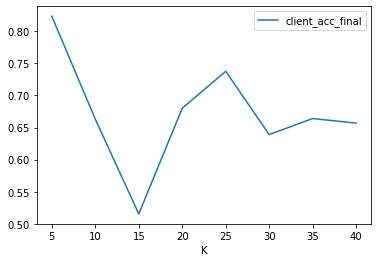

,K,server_acc_final
0,5,0.762483
1,10,0.708217
2,15,0.663800
3,20,0.706167
4,25,0.707483
5,30,0.695300
6,35,0.666250
7,40,0.659150


<AxesSubplot:xlabel='K'>

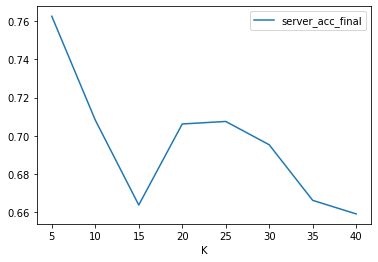

In [115]:
experiment = 'LotteryFL_MNIST_IID_R2_C0.4_K[5, 40, 8]_E10_B64_eta0.01_Acc0.5_rtrg0.25_rprn0.15'
mask = DF_EXPS['experiment'] == experiment

display(DF_EXPS[mask].loc[:, 'run'].to_frame().merge(DF_RUNS, on='run')[['K', 'client_acc_final']])
DF_EXPS[mask].loc[:, 'run'].to_frame().merge(DF_RUNS, on='run').plot(x='K', y='client_acc_final')
plt.show()
display(DF_EXPS[mask].loc[:, 'run'].to_frame().merge(DF_RUNS, on='run')[['K', 'server_acc_final']])
DF_EXPS[mask].loc[:, 'run'].to_frame().merge(DF_RUNS, on='run').plot(x='K', y='server_acc_final')

In [54]:
columns=['a', 'b', 'c']
df = pd.DataFrame(columns=columns)
df = df.append({'a': 1, 'b': 0.2, 'c': 'string'}, ignore_index=True)
df = df.append({'a': 2, 'b': 0.4, 'c': 'hello'}, ignore_index=True)
for i in range(3):
    if not 3 in df['a'].values:
        df = df.append({'a': 3, 'b': 0.6, 'c': 'string'}, ignore_index=True)
df

,a,b,c
0,1,0.2,string
1,2,0.4,hello
2,3,0.6,string


In [55]:
df.loc[df['a'] == 2].iloc[0].to_dict()

{'a': 2, 'b': 0.4, 'c': 'hello'}

In [28]:
df[(df['a'] == 1) & (df['b'] == 0.2)].empty

False

In [37]:
d = {'a':1}
d.get('b', 42)

42

In [39]:
s = 'abc'\
'def'
s

'abcdef'